In [39]:
import numpy as np
import scipy as sp
import csv
import bisect

import matplotlib.pyplot as plt
%matplotlib inline

#import george
#from george.kernels import ExpSquaredKernel

In [ ]:
#What's the point here?  
#See https://www.overleaf.com/5908814tkxdth#/19548885/ for problem statement
#Goals of this hack:
##make fake data in the form of true density field with probabilities of galaxy redshifts
##generate instantiations of observed density field based on those probabilities
##fit gaussian process to density field for each instantiation
##combine gaussian process samples to get estimator

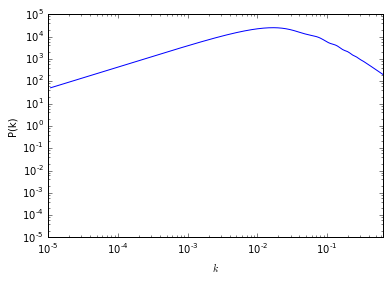

In [134]:
with open('ics_matterpow_0.dat','rb') as csvfile:
    tuples = (line.split(None) for line in csvfile)
    alldata = np.array([[float(pair[k]) for k in xrange(len(pair))] for pair in tuples])
    ks_all,pks_all = alldata.T[0],alldata.T[1]
    
plt.plot(ks_all,pks_all)
plt.semilogy()
plt.semilogx()
plt.xlim(1.e-5,2.*np.pi/10.)
plt.xlabel(r'$k$')
plt.ylabel(r'P(k)')

In [29]:
def cdf(weights):
    """
    cdf takes weights and makes them a normalized CDF
    """
    tot = sum(weights)
    result = []
    cumsum = 0.
    for w in weights:
      cumsum += w
      result.append(cumsum/tot)
    return(result)

def choice(pop, weights):
    """
    choice takes a population and assigns each element a value from 0 to len(weights) based on CDF of weights
    """
    #assert len(pop) == len(weights)
    cdf_vals = cdf(weights)
    x = np.random.random()
    index = bisect.bisect(cdf_vals,x)
    return(index,pop[index])

In [41]:
#power spectrum as input
#sample value at some ks
def sample_pk(pks_all,ks_all):
    k,p = choice(ks_all,np.sqrt(pks_all))
    return k,p
def sample_pks(N_modes,pks_all,ks_all):
    #take inverse fourier transform of k,p pairs
    #[make_datum(mean,cov) for n in xrange(N)]
    ks,pks = [],[]
    for n in xrange(N_modes):
        k,pk = sample_pk(pks_all,ks_all)
        ks.append(k)
        pks.append(pk)
    return(np.array(ks),np.array(pks))
# def make_dens_field_component(ks,pks):
# def make_dens_field(ks,pks):

In [142]:
def make_one_true():#xs_lims):
    #change this to sample from true distribution, specify MVN?
    #x = 10.*np.random.rand(1)
    #(xs_max,xs_min) = xs_lims
    x = 1./(2.*np.pi*min(ks))*np.random.rand(1)
    return x
def make_trues(Nlines,ks):
    #xs_lims = (2.*np.pi/min(ks),2.*np.pi/max(ks))
    xs = [make_one_true() for n in xrange(Nlines)]
    return(np.sort(np.array(xs)))

In [143]:
def sample_one_dens(pks,ks,x):
    deltaks = [np.random.normal(loc=0.,scale=np.sqrt(pk)) for pk in pks]
    deltax = sum([deltaks[n] * np.sin(ks[n]*x) for n in xrange(len(pks))])
    return deltax
def sample_all_dens(Nmodes,Nlines,pks_all,ks_all):
    ks,pks = sample_pks(Nmodes,pks_all,ks_all)
    xs = make_trues(Nlines,ks_all)
    deltas = []
    for n in xrange(Nlines):
        delta = sample_one_dens(pks,ks,xs[n])
        deltas.append(delta)
    return(ks,pks,xs,np.array(deltas))

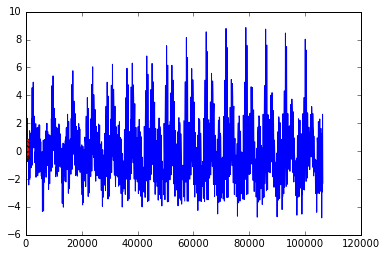

In [144]:
N_lines = 100
N_modes = 10

ks,pks,xt,y = sample_all_dens(N_modes,N_lines,pks_all,ks_all)

xs = np.arange(10.,1.e6*2.*np.pi/min(ks),100.)
toplot = [sum([np.sin(k*x) for k in ks]) for x in xs]

plt.plot(xs,toplot)
plt.plot(xt,y,'ro')
#plt.semilogy()

ValueError: x and y must have same first dimension

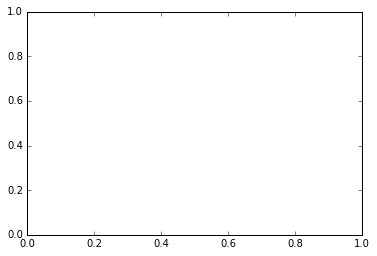

In [113]:
plt.plot(xt,y,'bo')
#print(xt)

In [15]:
#helper functions make observed catalog from true catalog given probabilities
#fixed the issue of metal lines actually being random
def add_one_to_cat(xt,p):#formerly chooser_one
    if np.random.uniform() < p:
        return xt
    return 10. * np.random.rand(1)#or bias this
def make_cat(xts,ps):
    output = []
    for n in xrange(len(ps)):
        output.append(add_one_to_cat(xts[n],ps[n]))
    return np.array(output)

In [ ]:
class tnorm(object):
    def __init__(self,mu,sig,ends):
        self.mu = mu
        self.sig = sig
        (self.min,self.max) = ends
        self.lo = self.loc(self.min)
        self.hi = self.loc(self.max)

    def loc(self,z):
        return (z-self.mu)/self.sig

    def phi(self,z):
        x = z/np.sqrt(2)
        term = sp.special.erf(x)
        return (1.+term)/2.

    def norm(self):
        return max(sys.float_info.epsilon,self.phi(self.hi)-self.phi(self.lo))

    def pdf(self,z):
        x = self.loc(z)
        pdf = sp.stats.norm.pdf(x)
        return pdf/(self.sig*self.norm())

    def cdf(self,z):
        x = self.loc(z)
        cdf = self.phi(x)-self.phi(self.lo)
        result = cdf/self.norm()
        #print('a cdf: {}/{}'.format(result,z))
        return result

    def rvs(self,J):
        func = sp.stats.truncnorm(self.lo,self.hi,loc=self.mu,scale=self.sig)
        return func.rvs(size=J)

In [14]:
def make_one_prob():
    #change this to be from arbitrary distribution
    #p = np.random.rand(1)
    #now 90% chance of having probability 0.9 and 10% of 0.1
    p = sp.stats.truncnorm()#fill me in!
    #p = np.random.uniform()
    #if p > 0.1:
    #    return 0.9
    return p
def make_probs(N):
    ps = [make_one_prob() for n in xrange(N)]
    return ps

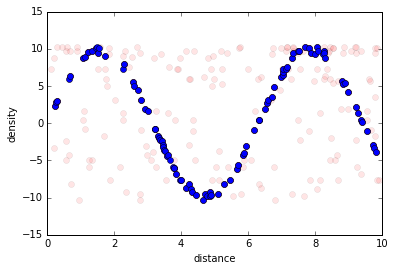

In [27]:
#try bigger samples!
nlines = 100
nsurvs = 10

#make the probabilities, could be smarter, need not be random for all lines
#these are scalar posteriors p(Ly-a|data)
p = make_probs(nlines)

#choose density measurement locations in physical distances
#there's actually no reason for these to be randomly sampled if they represent density values
xt = 10 * np.sort(np.random.rand(nlines))
#xt = make_trues(nlines)

#fake distances for misclassified metal lines; really should be random lines swapped with Ly-a
#try different prescriptions for this
#actually, this is fairly realistic because when it's a metal line, we don't know which one
#but it should have a bit of bias towards metal lines due to low-z galaxies and Ly-a due to high-z clouds
#xf = 10 * np.random.rand(ngals)

yth = 10*np.sin(xt)

#errors on densities
#there's no reason the errors have to be the same, should they be proportional/related to probabilities?
yerr = 0.1*np.sqrt(np.abs(yth))#0.2 * np.ones_like(xt)

#this is a totally stupid density model, permitting negative densities
#try different functions here, something realistic for density field
#the right thing would be the truth as a sample from the real 2PCF
y = yth + yerr * np.random.randn(len(xt))

#instantiations of the survey
xos = [make_cat(xt,p) for n in xrange(nsurvs)]

#plt.plot(xf,y)
for xo in xos:
    plt.plot(xo,y,'ro',alpha=1./nsurvs)
#plt.legend()
#print(p)
plt.plot(xt,y,'bo')
plt.xlabel('distance')
plt.ylabel('density')
plt.savefig('inputs.png')

In [20]:
#stolen wholesale from DFM's documentation
#http://dan.iel.fm/george/current/user/quickstart/#a-simple-example

# Set up the Gaussian process.
kernel = ExpSquaredKernel(1.0)

In [21]:
gp_tru = george.GP(kernel)

# Pre-compute the factorization of the matrix.
gp_tru.compute(xt, yerr)

# Compute the log likelihood.
print(gp_tru.lnlikelihood(y))

gp_obss = [george.GP(kernel) for n in xrange(nsurvs)]

# Pre-compute the factorization of the matrix.
for n in xrange(nsurvs):
    gp_obss[n].compute(xos[n], yerr)
    # Compute the log likelihood.
    print(gp_obss[n].lnlikelihood(y))

-329.611928362
-401.192123864
-409.368237685
-410.29728344
-453.878353902
-382.19964236
-439.901073065
-380.632647165
-381.123240931
-449.19068661
-420.584160981


In [22]:
t = np.linspace(0, 10, 500)

mu_tru, cov_tru = gp_tru.predict(y, t)
std_tru = np.sqrt(np.diag(cov_tru))

mu_obss,cov_obss = [],[]
for n in xrange(nsurvs):
    mu_obs, cov_obs = gp_obss[n].predict(y, t)
    mu_obss.append(mu_obs)
    cov_obss.append(cov_obs)
    #std_obs = np.sqrt(np.diag(cov_obs))

/Users/aimalz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()
/Users/aimalz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


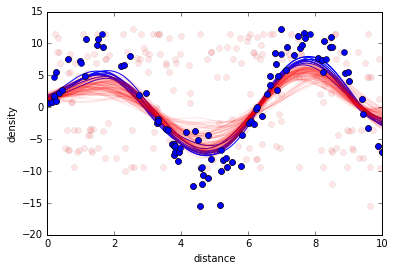

In [23]:
#change this to plot posteriors not just samples
nsamps = 10
toplot_tru = np.random.multivariate_normal(mu_tru,cov_tru,nsamps)
toplot_obss = [np.random.multivariate_normal(mu_obss[n],cov_obss[n],nsamps) for n in xrange(nsurvs)]
for s in xrange(nsamps):
    plt.plot(t,toplot_tru[s],c='b')
for n in xrange(nsurvs):
    for s in xrange(nsamps):
        plt.plot(t,toplot_obss[n][s],c='r',alpha=1./nsurvs)
    plt.plot(xos[n],y,'ro',alpha=1./nsurvs)
plt.plot(xt,y,'bo')
plt.xlabel('distance')
plt.ylabel('density')
plt.savefig('outputs.png')
#this is essentially fitting to the randomly chosen most certain points 
#because they most consistently appear in the true location in the samples

In [ ]:
#how to combine posterior samples from different survey instantiations?
#importance sampling, jackknifing, bootstrap, etc.